In [1]:
import sys, os
sys.path.append("..")
from yolo.models import YOLOv1
from yolo.data.VOC_Dataset import VOC_Dataset
from data import DATA_HOME

from ipdb import set_trace
from torch.utils.data import DataLoader
from numpy import array
from multiprocessing import cpu_count
import random 
import torch
import pandas as pd

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

random.seed(1)
torch.manual_seed(1)

In [2]:
import platform

_voc_root = f"{DATA_HOME}/VOCdevkit/VOC2007"
voc_ds = VOC_Dataset(_voc_root)
BS = 2

def collate_fn(data):
    # output: 7 * 7 * 30
    # S * S * ((x, y, w, h, confidence) * B=2 + C=20)
    # make img batch and label batch
    imgs, labels, classes = zip(*data)
    # inhomegenous shape label, since each image has different number of objects
    # label's dimension: (Batch size, # of objects in each image, 4 coords)
    return torch.tensor(array(imgs), dtype=torch.float), labels, classes
    
if platform.system() == "Windows":
    loader = DataLoader(voc_ds, batch_size=BS, pin_memory=True, shuffle=True, collate_fn=collate_fn)
else:
    loader = DataLoader(voc_ds, batch_size=BS, pin_memory=True, shuffle=True, num_workers=4, collate_fn=collate_fn)

class dict:  {'cat': 0, 'car': 1, 'dog': 2, 'person': 3, 'train': 4, 'sofa': 5, 'cow': 6, 'chair': 7, 'bottle': 8, 'bus': 9, 'diningtable': 10, 'bicycle': 11, 'aeroplane': 12, 'tvmonitor': 13, 'motorbike': 14, 'sheep': 15, 'horse': 16, 'bird': 17, 'pottedplant': 18, 'boat': 19}


In [3]:

test = torch.randn(3, 448, 448).unsqueeze(0).to(device=device)
yolo = YOLOv1().to(device=device)

S = 7 # num of rows/cols
C = 20 # num of classes
B = 2 # num of bounding boxes

lamba_coord = 5
lamba_noobj = 0.5


def IOU(output, label):
    """Calculate the intersection over union of two sets rectangles

    Keyword arguments
    both output and label are (x, y, w, h)
    """
    
    output = (
        output[0] - output[2] / 2,
        output[1] - output[3] / 2,
        output[0] + output[2] / 2,
        output[1] + output[3] / 2,
    )

    label = (
        label[0] - label[2] / 2,
        label[1] - label[3] / 2,
        label[0] + label[2] / 2,
        label[1] + label[3] / 2,
    )

    x_inter = min(output[2], label[2]) - max(output[0], label[0])
    y_inter = min(output[3], label[3]) - max(output[1], label[1])

    if x_inter <= 0.0 or y_inter <= 0.0:
        return 0.0

    intersection = x_inter * y_inter

    overlapped_union = (output[2] - output[0]) * (output[3] - output[1]) + (label[2] - label[0]) * (
        label[3] - label[1]
    )
    
    return intersection / (overlapped_union - intersection)

# sanity checks of IOU
coords = (0.25, 0.25, 0.5, 0.5)
y_coords1 = (0.5, 0.575, 0.5, 0.35)
y_coords2 = (0.575, 0.5, 0.35, 0.5)
y_coords3 = (0.25, 0.25, 0.5, 0.5)
y_coords4 = (0.25, 0, 0.5, 0)
y_coords5 = (0.625, 0.375, 0.25, 0.75)
y_coords6 = (0.2, 0.25, 0.2, 0.3)

def float_eqs(a, b, decimal_pt):
    eps = 10 ** (-decimal_pt)
    return abs(a-b) < eps

assert float_eqs(IOU(coords, y_coords1), 0.025 / (0.5*0.5 + 0.5*0.35 - 0.025), 5)
assert float_eqs(IOU(coords, y_coords2), 0.025 / (0.5*0.5 + 0.5*0.35 - 0.025), 5)
assert float_eqs(IOU(coords, y_coords3), 1, 5)
assert float_eqs(IOU(coords, y_coords4), 0, 5)
assert float_eqs(IOU(coords, y_coords5), 0, 5)
assert float_eqs(IOU(coords, y_coords6), 0.06 / (0.5*0.5), 5)

In [4]:
from collections import defaultdict as dd

def yolo_loss(res_mat: torch.tensor, label_mat: list, class_mat: list, loss_df: pd.DataFrame):
    """calcalate batch yolo loss, @param res_mat: (batch_size, B*5+C, S, S)"""
    loss1 = torch.tensor(0.).to(device=device)
    loss2 = torch.tensor(0.).to(device=device)
    loss3 = torch.tensor(0.).to(device=device)
    loss4 = torch.tensor(0.).to(device=device)
    loss5 = torch.tensor(0.).to(device=device)
    # calculate loss for every bounding box in every cell
    for b, batch in enumerate(res_mat):
        # assign labels bbox to cell indices
        stride = 1. / S
        label_inds = dd(list)
        label_class = {}
        for idx, (x, y, w, h) in enumerate(label_mat[b]):
            xi, yi = int(x // stride), int(y // stride)
            label_inds[(xi, yi)].append((x, y, w, h))
            label_class[(x, y, w, h)] = class_mat[b][idx]
        
        # print("label class", label_class, b, batch.shape)
        # iterate cell and calculate loss
        for i in range(batch.shape[1]):
            for j in range(batch.shape[2]):
                cell = batch[:, i, j]

                if (i, j) in label_inds:
                    yprobs = torch.tensor([0.] * C).to(device=device)
                    for x, y, w, h in label_inds[i, j]:
                        for k in range(0, B*5, 5):
                            x_, y_, w_, h_, c_ = cell[k:k+5]
                            loss1 += lamba_coord * ((x-x_) ** 2 + (y-y_) ** 2) # yolo loss term 1
                            loss2 += lamba_coord * ((w ** 0.5 - abs(w_) ** 0.5)**2 + (h ** 0.5 - abs(h_) ** 0.5)**2) # yolo loss term 2
                            loss3 += (IOU((x, y, w, h), (x_, y_, w_, h_)) - c_) ** 2 # yolo loss term 3
                        yprobs[label_class[x, y, w, h]] = 1.  
                    loss5 += ((yprobs - cell[-C:]) ** 2).sum() # yolo loss term 5
                else:
                    for k in range(4, B*5, 5):
                        _c = cell[k]
                        loss4 += _c ** 2 * lamba_noobj # yolo loss term 4
        # print("xywh: " , x_, y_, w_, h_, c_)
        # print("label: ", x, y, w, h)
    loss_df = pd.concat((loss_df, pd.DataFrame([[loss1.item(), loss2.item(), loss3.item(), loss4.item(), loss5.item()]], columns=loss_df.columns)), ignore_index=True)
    return loss1 + loss2 + loss3 + loss4 + loss5, loss_df
    # print("ret: ", res_mat.shape)
    

xywh:  tensor(0.0066, device='cuda:0', grad_fn=<UnbindBackward0>) tensor(0.0099, device='cuda:0', grad_fn=<UnbindBackward0>) tensor(0.0177, device='cuda:0', grad_fn=<UnbindBackward0>) tensor(0.0005, device='cuda:0', grad_fn=<UnbindBackward0>) tensor(-0.0118, device='cuda:0', grad_fn=<UnbindBackward0>)
label:  0.318 0.46846846846846846 0.482 0.9159159159159159
xywh:  tensor(-0.0027, device='cuda:0', grad_fn=<UnbindBackward0>) tensor(0.0098, device='cuda:0', grad_fn=<UnbindBackward0>) tensor(-0.0144, device='cuda:0', grad_fn=<UnbindBackward0>) tensor(0.0095, device='cuda:0', grad_fn=<UnbindBackward0>) tensor(-0.0057, device='cuda:0', grad_fn=<UnbindBackward0>)
label:  0.716 0.13066666666666665 0.986 0.8666666666666667
xywh:  tensor(0.0073, device='cuda:0', grad_fn=<UnbindBackward0>) tensor(-0.0166, device='cuda:0', grad_fn=<UnbindBackward0>) tensor(-0.0093, device='cuda:0', grad_fn=<UnbindBackward0>) tensor(-0.0169, device='cuda:0', grad_fn=<UnbindBackward0>) tensor(0.0164, device='cuda:

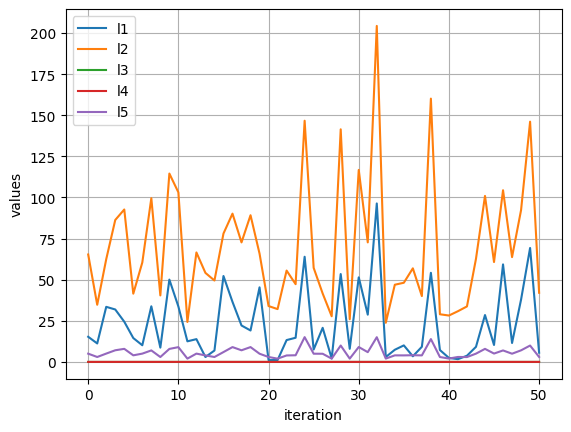

RuntimeError: Parent directory C:\Users\sxing/YOLO_MODELS does not exist.

In [5]:
from PIL import Image, ImageDraw
from sys import modules
import torch.optim as optim
import matplotlib.pyplot as plt

optimizer = optim.Adam(yolo.parameters(), lr=1e-6)
torch.cuda.empty_cache()

if 'google.colab' in sys.modules:
    save_dir = os.environ["GDRIVE_MOUNT_DIR"]
else:
    save_dir = os.path.expanduser("~/YOLO_MODELS")
loss_df = pd.DataFrame(columns=["l1", "l2", "l3", "l4", "l5"])

for _id, sample in enumerate(loader):
    # forward-propagate
    batch, labels, classes = sample
    res = yolo(batch.to(device=device))
    # print(res.shape, len(labels[2]), classes[2])
    loss, loss_df = yolo_loss(res, labels, classes, loss_df)
    # set_trace()

    # back-propagate
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # record
    if _id and _id % 50 == 0:
        print("loss ", loss)
        print("loss_df: ", loss_df)
        for col in loss_df.columns:
            plt.plot(loss_df[col], label=col)
        plt.xlabel("iteration")
        plt.ylabel("values")
        plt.legend()
        plt.grid(True)
        plt.show()
        checkpoint = {
            'model': yolo.state_dict(),
            'optimizer': optimizer.state_dict(),
            'iteration': _id,
            'train_loss': loss,
            # 'val_loss': val_loss
        }
        torch.save(checkpoint, f"{save_dir}/yolov1_{_id}.pth")
    # showing the image with labels
    # res_img = Image.fromarray((batch[0] * 255).permute(1, 2, 0).byte().numpy())
    # draw = ImageDraw.Draw(res_img)
    # for pc in labels[0]:
    #     draw.rectangle((448*pc[0], 448*pc[1], 448*pc[2], 448*pc[3]), outline="red")
    # res_img.show()

    
    